In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_table('SMSSpamCollection', header=None, quoting=3, names=['class', 'message'])

In [2]:
print len(df)
print df.shape
print df.head()

5574
(5574, 2)
  class                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
df_train, df_test, y_train, y_test = train_test_split(df['message'], df['class'], test_size=0.33, random_state=42)

In [5]:
# Vectorizing

vectorizer = TfidfVectorizer(use_idf=True)

X_train = vectorizer.fit_transform(df_train)
X_test = vectorizer.transform(df_test)

In [5]:
# We will use Gradient Boosting Classifier which should give as better results than logistic Regression in our case

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05, max_depth=8, random_state=0, min_samples_leaf=0.001)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test.toarray())

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      1585
       spam       0.99      0.89      0.94       255

avg / total       0.98      0.98      0.98      1840

[[1582    3]
 [  27  228]]


In [6]:
# The model is better than standard Logistic Regression and better than our customized Logistic Regression. 
# Spam precision is really good (only 3 ham messages classified as spam) and Spam recall is better as well.
# Still some Spam messages were classified as Ham. We can print them so we can see what kind of messages we should 
# focus on in the next iteration of the algorithm enhancement.

print df_test[(y_test == 'spam') & (y_pred == 'ham')]
print len(df_test[(y_test == 'spam')])

5030    I'd like to tell you my deepest darkest fantas...
1745    Someone has conacted our dating service and en...
3742                                        2/2 146tf150p
2915    Sorry! U can not unsubscribe yet. THE MOB offe...
2663    Hello darling how are you today? I would love ...
3848    Fantasy Football is back on your TV. Go to Sky...
4821    Check Out Choose Your Babe Videos @ sms.shsex....
751     Do you realize that in about 40 years, we'll h...
2770    Burger King - Wanna play footy at a top stadiu...
881     Reminder: You have not downloaded the content ...
3864    Oh my god! I've found your number again! I'm s...
4047        Win a £1000 cash prize or a prize worth £5000
1777                    Call FREEPHONE 0800 542 0578 now!
4506    Mobile Club: Choose any of the top quality ite...
3064    Hi babe its Jordan, how r u? Im home from abro...
1699    Free msg. Sorry, a service you ordered from 81...
731     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
3360    Sorry 

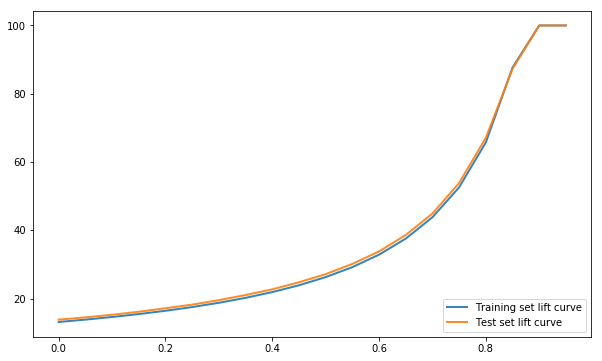

In [15]:
# Cumultative Lift Charts

# scoring training and test sets
y_tr_pred = clf.predict_proba(X_train.toarray())[:,1]
y_ts_pred = clf.predict_proba(X_test.toarray())[:,1]

# sorting them
tr = sorted(zip(y_tr_pred, y_train == 'spam'), key=lambda x: x[0], reverse=True)
ts = sorted(zip(y_ts_pred, y_test == 'spam'), key=lambda x: x[0], reverse=True)

# average score in each bin
cumulated = {0: [], 1: []}
for i, s in enumerate([tr, ts]):
    scores = []
    for group in np.array_split(s, 20):
        scores += [x[1] for x in group]
        cumulated[i].append(np.mean(scores) * 100)

# plotting
bins = [x / 100. for x in reversed(range(0 , 100, 5))]

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(bins, cumulated[0], lw=2, alpha=0.9, label="Training set lift curve")
plt.plot(bins, cumulated[1], lw=2, alpha=0.9, label="Test set lift curve")

plt.legend(loc='lower right')

# Cumultative Lift Charts for training and test sets are smooth and close to each other. Thus, the model
# is less likely to be overtrained or overfitted.

In [17]:
# We can try to create an ensemble model using also Logistic Regression and see if it can improve our classificator

clf2 = LogisticRegression(class_weight='balanced')
clf2.fit(X_train, y_train)

def ensemble_predict(X_test, w1, w2, t=0.5):   
    prs = zip(clf.predict_proba(X_test.toarray()), clf2.predict_proba(X_test))
    indices = [1 if w1*p1[1] + w2*p2[1] > t else 0 for p1, p2 in prs]
    
    return clf.classes_[indices]

y_pred = ensemble_predict(X_test, 0.6, 0.4)

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      1585
       spam       0.99      0.90      0.94       255

avg / total       0.99      0.99      0.99      1840

[[1583    2]
 [  25  230]]


In [ ]:
# Obtained model is indeed the best that we have acquired so far with better precision, recall and weighted f1-score of 0.99